In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RAW_PATH = "data\reference\drx_2022_2025_0829_split.csv"
RAW_PATH_df = pd.read_csv(RAW_PATH)

RAW_PATH_df["date"] = pd.to_datetime(RAW_PATH_df["date"], errors = "coerce")
RAW_PATH_df ["win"] = RAW_PATH_df["w_l"].map({"Win":1, "Loss":0})

cutoff = pd.Timestamp("2022-11-06")
RAW_PATH_df["period"] = np.where(
    RAW_PATH_df["date"] <= cutoff,
    "Peak", "Post-Peak"
)

In [7]:
positions = ["top", "jg", "mid", "bot", "sup"]
player_cols = [f"player_{p}" for p in positions]

missing = [c for c in player_cols if c not in RAW_PATH_df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

RAW_PATH_df = RAW_PATH_df.sort_values("date").reset_index(drop=True)

In [17]:
positions = ["top", "jg", "mid", "bot", "sup"]
player_cols = [f"player_{p}" for p in positions]

# baseline 기준 로스터 이탈 이벤트 계산
def baseline_change_events(series: pd.Series) -> pd.Series:
    baseline = str(series.iloc[0]) if len(series) > 0 else ""
    out = []
    event = 0
    prev_is_baseline = True

    for v in series.astype(str).fillna(""):
        is_baseline = (v == baseline)
        
        if prev_is_baseline and not is_baseline:
            event += 1
        out.append(event if not is_baseline else 0)
        prev_is_baseline = is_baseline

    return pd.Series(out, index=series.index)

# 라인별 baseline 이탈 이벤트 생성
for p in positions:
    RAW_PATH_df[f"chg_event_{p}"] = baseline_change_events(RAW_PATH_df[f"player_{p}"])

# baseline이 아닌 라인
RAW_PATH_df["roster_change_cnt"] = (
    RAW_PATH_df[[f"chg_event_{p}" for p in positions]].gt(0).sum(axis=1)
)

show_cols = (
    ["date", "period", "w_l", "win", "vs", "side"] +
    player_cols +
    [f"chg_event_{p}" for p in positions] +
    ["roster_change_cnt"]
)

RAW_PATH_df[show_cols].head(300)

,date,period,w_l,win,vs,side,player_top,player_jg,player_mid,player_bot,player_sup,chg_event_top,chg_event_jg,chg_event_mid,chg_event_bot,chg_event_sup,roster_change_cnt
0,2022-01-12,Peak,Loss,0.0,Liiv SANDBOX,Blue,Kingen,Pyosik,Zeka,Deft,BeryL,0,0,0,0,0,0
1,2022-01-12,Peak,Loss,0.0,Liiv SANDBOX,Blue,Kingen,Pyosik,Zeka,Deft,BeryL,0,0,0,0,0,0
2,2022-01-14,Peak,Loss,0.0,Gen.G,Red,Kingen,Pyosik,Zeka,Deft,BeryL,0,0,0,0,0,0
3,2022-01-14,Peak,Loss,0.0,Gen.G,Blue,Kingen,Pyosik,Zeka,Deft,BeryL,0,0,0,0,0,0
4,2022-01-20,Peak,Loss,0.0,T1,Blue,Kingen,Pyosik,Zeka,Deft,BeryL,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-08-01,Post-Peak,Win,1.0,OKSavingsBank BRION,Red,Frog,Sponge,kyeahoo,Teddy,Pleata,2,9,2,2,2,5
296,2024-08-03,Post-Peak,Loss,0.0,BNK FEARX,Blue,Frog,Sponge,kyeahoo,Teddy,Pleata,2,9,2,2,2,5
297,2024-08-03,Post-Peak,Loss,0.0,BNK FEARX,Red,Frog,Sponge,kyeahoo,Teddy,Pleata,2,9,2,2,2,5
298,2024-08-07,Post-Peak,Loss,0.0,Gen.G,Blue,Rascal,Sponge,SeTab,Teddy,Pleata,2,9,2,2,2,5


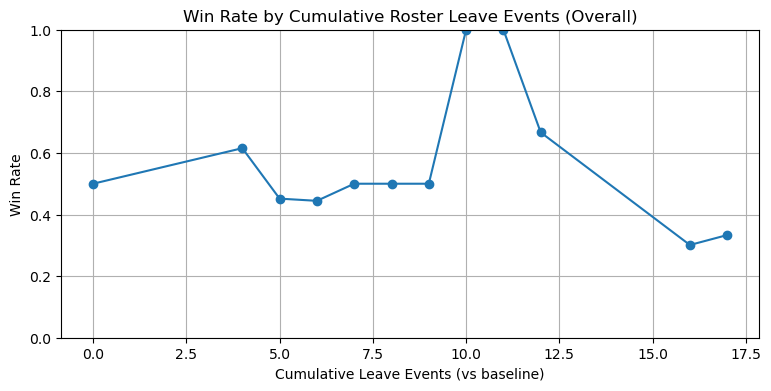

,roster_event_total_sofar,games,winrate
0,0,12,0.500000
1,4,26,0.615385
2,5,31,0.451613
3,6,27,0.444444
4,7,2,0.500000
5,8,2,0.500000
6,9,4,0.500000
7,10,2,1.000000
8,11,4,1.000000
9,12,21,0.666667


In [22]:
# 라인 별 baseline 이탈 이벤트 누적 값
for p in positions:
    RAW_PATH_df[f"event_sofar_{p}"] = RAW_PATH_df[f"chg_event_{p}"].cummax()

# 5개 라인 누적 baseline 이탈 이벤트 합
RAW_PATH_df["roster_event_total_sofar"] = RAW_PATH_df[[f"event_sofar_{p}" for p in positions]].sum(axis=1)

summary_event_period = (
    RAW_PATH_df.groupby(["period", "roster_event_total_sofar"])
      .agg(games=("win","count"), winrate=("win","mean"))
      .reset_index()
      .sort_values(["period", "roster_event_total_sofar"])
)

# 누적 로스터 이탈 이벤트별 승률
summary_event = (
    RAW_PATH_df.groupby("roster_event_total_sofar")
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
      .sort_values("roster_event_total_sofar")
)

# 전체 데이터 승률 시각화
plt.figure(figsize=(9,4))
plt.plot(summary_event["roster_event_total_sofar"], summary_event["winrate"], marker="o")
plt.ylim(0, 1)
plt.title("Win Rate by Cumulative Roster Leave Events (Overall)")
plt.xlabel("Cumulative Leave Events (vs baseline)")
plt.ylabel("Win Rate")
plt.grid(True)
plt.show()

summary_event


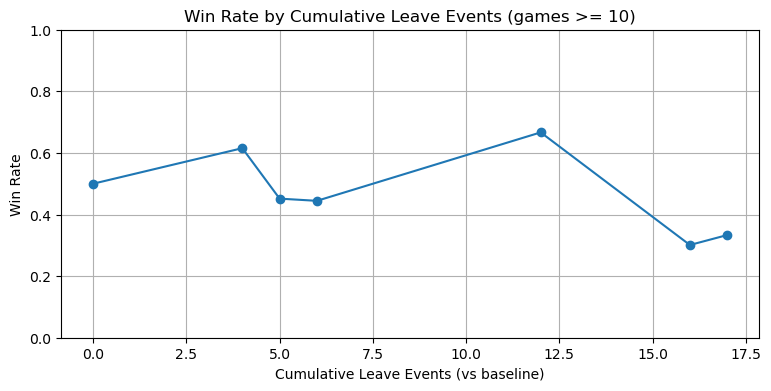

,roster_event_total_sofar,games,winrate
0,0,12,0.500000
1,4,26,0.615385
2,5,31,0.451613
3,6,27,0.444444
9,12,21,0.666667
10,16,93,0.301075
11,17,183,0.333333


In [23]:
# 표본 수 부족으로 인한 왜곡 방지
min_games = 10
summary_event_f = summary_event[summary_event["games"] >= min_games]

plt.figure(figsize=(9,4))
plt.plot(summary_event_f["roster_event_total_sofar"], summary_event_f["winrate"], marker="o")
plt.ylim(0, 1)
plt.title(f"Win Rate by Cumulative Leave Events (games >= {min_games})")
plt.xlabel("Cumulative Leave Events (vs baseline)")
plt.ylabel("Win Rate")
plt.grid(True)
plt.show()

summary_event_f


In [ ]:
# 누적 이탈 이벤트가 0~4 수준일 때 승률은 약 50~60% 수준을 유지한다.
# 누적 이탈 이벤트가 5~6 구간에서는 승률이 일시적으로 하락하지만,
# 이후 12 이벤트 수준까지는 다시 상승하는 구간이 관찰된다.
# 그러나 누적 이탈 이벤트가 15 이상으로 증가하는 구간에서는
# 승률이 급격히 하락하며 30% 초반 수준까지 떨어진다.